In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
import albumentations as A
import tensorflow_advanced_segmentation_models as tasm
import matplotlib.pyplot as plt
from glob import glob
from tensorflow.keras import layers
from tensorflow.keras import Model

2024-11-27 10:48:47.347924: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-27 10:48:47.447452: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-27 10:48:47.552391: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-27 10:48:47.629530: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-27 10:48:47.651580: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-27 10:48:47.809548: I tensorflow/core/platform/cpu_feature_gu

# 1. Построение архитектуры кодер-декодер U-Net

In [2]:
def EncoderBlock(input_features, filters, kernel_size=(3, 3), activation='relu'):
    """
    Создает блок энкодера, состоящий из двух сверток и одного слоя пуллинга.
    """
    conv = layers.Conv2D(filters, kernel_size, activation=activation, padding='same')(input_features)
    conv = layers.Conv2D(filters, kernel_size, activation=activation, padding='same')(conv)
    pool = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    return conv, pool

def DecoderBlock(input_features, encoder_features, upsample_type, filters, kernel_size=(3, 3), activation='relu'):
    """
    Создает блок декодера с возможностью выбора типа апсэмплинга.
    """
    
    if(upsample_type == 'conv_transpose'):
        up_features = layers.Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(input_features)
    elif(upsample_type == 'upsample'):
        up_features = layers.UpSampling2D((2, 2), interpolation='bilinear')(input_features)
    x = layers.Concatenate()([encoder_features, up_features])
    x = layers.Conv2D(filters, kernel_size, activation=activation, padding='same')(x)
    x = layers.Conv2D(filters//2, kernel_size, activation=activation, padding='same')(x)
    return x

def U_Net(input_size, filters=[64, 128, 256, 512, 1024], num_classes=1, upsample_type='upsample', activation='relu'):
    """
    Собирает архитектуру U-Net с заданными параметрами.
    """
    # Входной слой
    inputs = layers.Input(shape=input_size)
    
    # Кодирующая сеть (CNN)
    conv1, pool1 = EncoderBlock(input_features=inputs, filters=filters[0], kernel_size=(3, 3), activation=activation)
    conv2, pool2 = EncoderBlock(input_features=pool1, filters=filters[1], kernel_size=(3, 3), activation=activation)
    conv3, pool3 = EncoderBlock(input_features=pool2, filters=filters[2], kernel_size=(3, 3), activation=activation)
    conv4, pool4 = EncoderBlock(input_features=pool3, filters=filters[3], kernel_size=(3, 3), activation=activation)
    
    # Мост между кодером и декодер (передает информацию о высокоуровневых признаках от encoder к decoder)
    bridge = layers.Conv2D(filters[4], (3, 3), activation='relu', padding='same')(pool4)
    bridge = layers.Conv2D(filters[3], (3, 3), activation='relu', padding='same')(bridge)
    
    # Декодирующая сеть
    decoder1 = DecoderBlock(input_features=bridge, encoder_features=conv4, upsample_type=upsample_type, filters=filters[3], kernel_size=(3, 3), activation=activation)
    decoder2 = DecoderBlock(input_features=decoder1, encoder_features=conv3, upsample_type=upsample_type, filters=filters[2], kernel_size=(3, 3), activation=activation)
    decoder3 = DecoderBlock(input_features=decoder2, encoder_features=conv2, upsample_type=upsample_type, filters=filters[1], kernel_size=(3, 3), activation=activation)
    decoder4 = DecoderBlock(input_features=decoder3, encoder_features=conv1, upsample_type=upsample_type, filters=filters[0], kernel_size=(3, 3), activation=activation)
    
    # Классификатор (если задача бинарной классификации, то используем 1 нейрон/фильтр, в противном случае используем num_classes)
    if(num_classes == 1):
        outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder4)
    else:
        outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(decoder4)

    return Model(inputs=inputs, outputs=outputs)

In [3]:
def build_model(input_size):
    """
    Создает и компилирует модель U-Net с заданными параметрами.
    Примечания:
        - Фильтры в сверточных слоях U-Net установлены на [32, 64, 128, 256, 512].
        - В зависимости от количества классов (num_classes) выбирается соответствующая функция потерь:
            - Если num_classes равно 1, используется бинарная фокальная ошибка + DiceLoss.
            - Если num_classes больше 1, используется категориальная фокальная ошибка + DiceLoss.
        - Модель компилируется с оптимизатором Adam с начальными параметрами и метрикой IOU (Intersection over Union) с порогом 0.5.
    """
    model = U_Net(input_size=input_size, filters=[32, 64, 128, 256, 512], num_classes=num_classes, upsample_type='upsample')
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    if(num_classes == 1):
        loss = 10 * tasm.losses.BinaryFocalLoss() + tasm.losses.DiceLoss()
    else:
        loss = 10 * tasm.losses.CategoricalFocalLoss() + tasm.losses.DiceLoss()
    model.compile(optimizer=optimizer, loss=loss, metrics=[tasm.metrics.IOUScore(threshold=0.5)])
    return model

In [4]:
def build_tasm_model():
    base_model, layers, layer_names = tasm.create_base_model(name="efficientnetb3", weights="imagenet", height=img_size, width=img_size)
    model = tasm.SpatialOCRNet(n_classes= 2 if num_classes==1 else num_classes, base_model=base_model, output_layers=layers, backbone_trainable=True)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    if(num_classes == 1):
        loss = 10 * tasm.losses.BinaryFocalLoss() + tasm.losses.DiceLoss()
    else:
        loss = 10 * tasm.losses.CategoricalFocalLoss() + tasm.losses.DiceLoss()
    model.compile(optimizer=optimizer, loss=loss, metrics=[tasm.metrics.IOUScore(threshold=0.5)])
    return model

In [5]:
def trainModel(train_dataset, val_dataset, img_size, epochs):
    """
    Обучает модель U-Net для задачи семантической сегментации на заданных наборах данных.

    Args:
        train_dataset (tf.data.Dataset): Тренировочный набор данных, подготовленный для обучения модели.
        val_dataset (tf.data.Dataset): Валидационный набор данных для оценки модели во время обучения.
        img_size (int): Размер изображения (высота и ширина), используемый в модели.
        batch_size (int): Размер батча, используемый в процессе обучения.
        epochs (int): Количество эпох для обучения модели.

    Returns:
        tf.keras.callbacks.History: История обучения модели, содержащая информацию о значениях потерь и метрик на каждой эпохе.
    """
    model = build_model((img_size, img_size, 3))
    model.summary()
    # model = build_tasm_model() # Загрузка готовой модели из библиотеки tasm
    checkpoint_callback = ModelCheckpoint('seg_model.weights.h5', 
                                          monitor='val_loss',
                                          save_best_only=True,
                                          save_weights_only=True,
                                          verbose=1)
    history = model.fit(train_dataset,
                        epochs=epochs,
                        callbacks = [checkpoint_callback],
                        validation_data=val_dataset)
    return history

# 2. Формирование класса набора данных tf.data.Dataset для задачи семантической сегментации

In [6]:
class SemanticSegmentationDataset:
    """
    Класс для создания датасета для задачи семантической сегментации.

    Args:
        image_paths (list): Список путей к изображениям.
        mask_paths (list): Список путей к маскам.
        img_size (int): Желаемый размер изображений.
        unique_classes (list): Список уникальных классов вашей задачи.
        num_classes (int): Количество классов для сегментации.
        batch_size (int, optional): Размер батча. По умолчанию 32.
        shuffle (bool, optional): Нужно ли перемешивать данные. По умолчанию True.
        transforms (list, optional): Применение функции преобразований над изображениями (аугментация). По умолчанию None.

    Methods:
        __call__(): Создает и возвращает tf.data.Dataset для обучения или валидации/тестирования.
        open_paths(image_path, mask_path): Открывает изображение и маску по заданным путям.
        apply_transform(image, mask): Применяет преобразования (аугментацию) для текущего набора данных.
        process_mask(image, mask): Обрабатывает маску, преобразуя её в бинарный формат (для бинарной сегментации) или one-hot кодирование (для многоклассовой сегментации).
    """
    def __init__(self,
                 image_paths,
                 mask_paths,
                 img_size,
                 unique_classes,
                 num_classes,
                 batch_size=32,
                 shuffle=True,
                 transforms=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.img_size = img_size
        self.unique_classes = unique_classes
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.transforms = transforms
      
    def __call__(self):
        # 1. Создаем список пар (image, mask)
        dataset = tf.data.Dataset.from_tensor_slices((self.image_paths, self.mask_paths))
        
        # 2. Перемешивание (если требуется)
        if self.shuffle:
            dataset = dataset.shuffle(buffer_size=len(self.image_paths))
        
        # 3. Открытие и получение изображения с соответствующей маской
        dataset = dataset.map(lambda x, y: self.open_paths(x, y), num_parallel_calls=tf.data.AUTOTUNE)
        
        # 4. Аугментация (если указана)
        if self.transforms:
            dataset = dataset.map(lambda x, y: self.apply_transform(x, y), num_parallel_calls=tf.data.AUTOTUNE)
        
        # 5. Обработка маски (преобразование в бинарный / one-hot вид)
        dataset = dataset.map(lambda x, y: self.process_mask(x, y), num_parallel_calls=tf.data.AUTOTUNE)
        
        # 6. Формирование батчей
        dataset = dataset.batch(self.batch_size)
        dataset = dataset.prefetch(self.batch_size)
        
        return dataset

    def open_paths(self, image_path, mask_path):
        image = tf.io.read_file(image_path) # открытие image
        image = tf.image.decode_jpeg(image, channels=3)
        mask = tf.io.read_file(mask_path) # открытие mask
        mask = tf.image.decode_png(mask, channels=1)
        return image, mask
    
    def apply_transform(self, image, mask):
        def train_tranform(image, mask):
            image = np.array(image)
            data = {'image': image, 'mask': mask} # для albumentations необходимо подавать данные в формате словаря с указанием image и mask
            augmented = self.transforms(**data) # возвращает две картинки в augmented
            image, mask = augmented['image'], augmented['mask']
            return tf.convert_to_tensor(image, tf.float32), tf.convert_to_tensor(mask, tf.float32)
        
        image, mask = tf.numpy_function(func=train_tranform, inp=[image, mask], Tout=[tf.float32, tf.float32])
        image.set_shape([self.img_size, self.img_size, 3])
        mask.set_shape([self.img_size, self.img_size, self.num_classes])
        return image, mask
    
    def process_mask(self, image, mask):
        if num_classes == 1:
            # Преобразование маски в бинарную (0 или 1)
            mask = tf.where(mask > 0, 1, 0)
        else:
            # One-Hot кодирование
            mask = tf.equal(mask, tf.constant(list(self.unique_classes), dtype=tf.float32))
        mask = tf.cast(mask, tf.float32)
        return image, mask

# 3. Вспомогательные функции

In [7]:
def train_val_test_split(image_paths, mask_paths, ratios=(0.8, 0.1, 0.1)):
    """
    Разбивает пути к изображениям и маскам на тренировочный, валидационный и тестовый наборы данных.

    Args:
        image_paths (list): Список путей к изображениям.
        mask_paths (list): Список путей к маскам.
        ratios (tuple, optional): Кортеж, содержащий пропорции разбиения на тренировочный, валидационный и тестовый наборы.
                                  Значения по умолчанию: (0.8, 0.1, 0.1).

    Returns:
        tuple: Кортеж из трех элементов, каждый из которых содержит два списка: 
               (train_image_paths, train_mask_paths), 
               (val_image_paths, val_mask_paths), 
               (test_image_paths, test_mask_paths).
    """
    train_ratio, val_ratio, test_ratio = ratios[0], ratios[1], ratios[2]
    # Убедитесь, что списки совпадают по длине и соответствуют друг другу, а также пропорции разбиения дают в сумме 1
    assert len(image_paths) == len(mask_paths), "Количество изображений и масок должно совпадать!"
    assert (train_ratio + val_ratio + test_ratio) == 1, "train_ratio + val_ratio + test_ratio должны в сумме давать 1!"
    
    # Перемешивание данных (для случайного распределения в наборы)
    indices = np.arange(len(image_paths))
    np.random.shuffle(indices)
    
    image_paths = np.array(image_paths)[indices]
    mask_paths = np.array(mask_paths)[indices]
    
    # Пропорции для разбиения
    train_size = int(train_ratio * len(image_paths))
    val_size = int(val_ratio * len(image_paths))
    test_size = int(test_ratio * len(image_paths))
    
    # Разбиение на тренировочный, валидационный и тестовый наборы
    train_image_paths = image_paths[:train_size]
    train_mask_paths = mask_paths[:train_size]

    val_image_paths = image_paths[train_size:train_size + val_size]
    val_mask_paths = mask_paths[train_size:train_size + val_size]

    test_image_paths = image_paths[train_size + val_size:]
    test_mask_paths = mask_paths[train_size + val_size:]
    print("Train images and masks: " + str(len(train_image_paths)))
    print("Validation images and masks: " + str(len(val_image_paths)))
    print("Test images and masks: " + str(len(test_image_paths)))
    return (train_image_paths, train_mask_paths), (val_image_paths, val_mask_paths), (test_image_paths, test_mask_paths)

def find_classes(mask_paths):
    """
    Находит уникальные классы в масках изображений.

    Args:
        mask_paths (list): Список путей к маскам изображений.

    Returns:
        set: Множество уникальных классов, найденных в масках во всём наборе данных.
    """
    unique_classes = set()  # Создаем пустое множество для хранения уникальных классов
    
    for mask_path in mask_paths:
        image = cv2.imread(mask_path, 0)  # Чтение маски в режиме градаций серого (0)
        classes = np.unique(image)  # Нахождение уникальных значений классов в маске
        unique_classes.update(classes)  # Добавление уникальных классов в множество
    
    print(str(len(unique_classes)) + " unique classes have been found")
    print("Unique classes are: " + str(unique_classes) + '\n')
    return unique_classes  # Возвращаем множество уникальных классов

def filter_train_paths(image_paths, mask_paths, train_file_path):
    """
    Фильтрует список изображений и масок согласно приложенной таблице распределения

    Args:
        image_paths: Список изображений
        mask_paths: Список масок
        train_file_path: Путь к файлу csv с распределением image -> mask
        
    Returns:
        tuple из отфильтрованных image_paths и mask_paths
    """
    train = pd.read_csv(train_file_path)
    image_filtered_paths = [path for path in image_paths if os.path.basename(path) in train['ImageId'].values.tolist()]
    mask_filtered_paths = [path for path in mask_paths if os.path.basename(path) in train['MaskId'].values.tolist()]
    return image_filtered_paths, mask_filtered_paths

In [8]:
def display_images_and_masks(dataset, num_classes, color_palette=None, num_pairs=4):
    """
    Отображает изображения и соответствующие маски из набора данных.

    Args:
        dataset (tf.data.Dataset): Набор данных TensorFlow, содержащий пары (изображение, маска).
        num_classes (int): Количество классов в сегментации.
        num_pairs (int, optional): Количество пар изображений и масок для отображения. По умолчанию 4.

    Returns:
        None: Функция отображает результаты, но ничего не возвращает.
    """
    # Если у вас задача многоклассовой сегментации, то определяем цветовую палитру (RGB) для классов
    if(color_palette==None):
        colors = plt.get_cmap('tab20').colors  # Выбор палитры 'tab20' с 20 цветами
        color_palette = np.array(colors)[:num_classes] * 255  # Приведение значений к диапазону [0, 255]

    # Отображение первых n пар (изображение, маска) из train_dataset
    n = 4  # Количество пар для отображения

    plt.figure(figsize=(12, 5 * n))  # Размер фигуры

    for i, (image, mask) in enumerate(train_dataset.take(n)):
        # Берём первый элемент из батча
        image, mask = image[0], mask[0]

        # Отображаем изображение
        plt.subplot(n, 2, 2 * i + 1)
        plt.imshow(image.numpy(), vmin=0, vmax=1)
        plt.title("Image")
        plt.axis("off")

        # Если многоклассовая сегментация и маска в one-hot формате, преобразуем обратно в индексированное изображение
        if mask.shape[-1] > 1:
            mask = tf.argmax(mask, axis=-1)
            mask = tf.gather(color_palette, tf.cast(mask, tf.int32))

        # Отображаем маску
        plt.subplot(n, 2, 2 * i + 2)
        plt.imshow(mask.numpy().astype("uint8"), cmap='gray')
        plt.title("Mask")
        plt.axis("off")
    plt.show()



def display_plots(history):
    """
    Отображает графики обучения
    """
    plt.figure()
    plt.plot(history.history["iou_score"], label="training IoU")
    plt.plot(history.history["val_iou_score"], label="validation IoU")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(history.history["loss"], label="training loss")
    plt.plot(history.history["val_loss"], label="validation loss")
    plt.legend()
    plt.show()

# Пример: Многоклассовая семантическая сегментация

In [9]:
# Указываем пути к изображениям и соответствующим многоклассовым маскам
image_paths = sorted(glob('archive/images/images/*.jpg'))
mask_paths = sorted(glob('archive/masks/masks/*.jpg'))
image_paths, mask_paths = filter_train_paths(image_paths, mask_paths, 'archive/train.csv')
print(image_paths[:5])

['archive/images/images/ID00007637202177411956430_0.jpg', 'archive/images/images/ID00007637202177411956430_1.jpg', 'archive/images/images/ID00007637202177411956430_10.jpg', 'archive/images/images/ID00007637202177411956430_11.jpg', 'archive/images/images/ID00007637202177411956430_12.jpg']


In [10]:
# Если у вас задача многоклассовой сегментации и вы не уверены сколько в вашей задаче классов, используйте функцию find_classes, которая возвращает set из индексов классов
# Если вы уже точно знаете индексы ваших классов, вы можете записать их вручную в unique_classes = {}

unique_classes = find_classes(mask_paths)
num_classes = 1 if len(unique_classes) == 2 else len(unique_classes)

238 unique classes have been found
Unique classes are: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 198, 199, 200, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214,

In [12]:
# При отсутствии валидационных или тестовых выборок предлагается использовать кастомную функцию train_val_test_split
# Укажите в каких пропорциях вы хотите разделить ваши выборки, используя параметр ratios
(train_image_paths, train_mask_paths), (val_image_paths, val_mask_paths), (test_image_paths, test_mask_paths) = train_val_test_split(image_paths=image_paths,
                                                                                                                                     mask_paths=mask_paths,
                                                                                                                                     ratios=(0.6, 0.2, 0.2))

Train images and masks: 10024
Validation images and masks: 3341
Test images and masks: 3343


In [13]:
# Ознакомиться с перечнем передовых методов аугментации, а также поиграться с ними можно здесь:
# https://demo.albumentations.ai

img_size = 512
batch_size = 4

train_transforms = A.Compose([A.RandomCrop(height=img_size, width=img_size, p=1.0), 
                              A.HorizontalFlip(p=0.75),
                              A.VerticalFlip(p=0.75),
                              A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0) # нормализация изображения от 0 до 1
                             ],p=1.0)

val_transforms = A.Compose([A.CenterCrop(height=img_size, width=img_size, p=1.0),
                            A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0) # нормализация изображения от 0 до 1
                            ],p=1.0)

test_transforms = A.Compose([A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0) # нормализация изображения от 0 до 1
                            ],p=1.0)

train_dataset = SemanticSegmentationDataset(image_paths=train_image_paths,
                                            mask_paths=train_mask_paths,
                                            img_size = img_size,
                                            unique_classes = unique_classes,
                                            num_classes = num_classes,
                                            batch_size=batch_size,
                                            shuffle=True,
                                            transforms=train_transforms)()

val_dataset = SemanticSegmentationDataset(image_paths=val_image_paths,
                                          mask_paths=val_mask_paths,
                                          img_size = img_size,
                                          unique_classes = unique_classes,
                                          num_classes = num_classes,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          transforms=val_transforms)()

test_dataset = SemanticSegmentationDataset(image_paths=test_image_paths,
                                           mask_paths=test_mask_paths,
                                           img_size = None,
                                           unique_classes = unique_classes,
                                           num_classes = num_classes,
                                           batch_size=batch_size,
                                           shuffle=False,
                                           transforms=test_transforms)()

2024-11-27 10:50:03.830135: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: indices[185,313] = 29 is not in [0, 20)


InvalidArgumentError: {{function_node __wrapped__GatherV2_device_/job:localhost/replica:0/task:0/device:CPU:0}} indices[185,313] = 29 is not in [0, 20) [Op:GatherV2] name: 

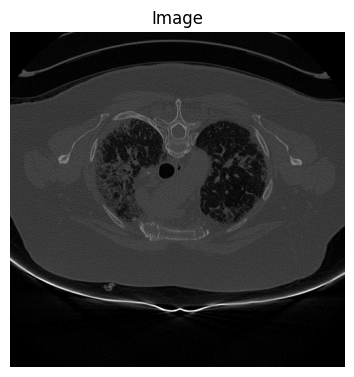

In [14]:
# Указываем цвета вручную (можно не указывать, тогда он сформирует случайным образом цвета)
# color_palette = tf.constant([
#     [0, 0, 255],       # Класс 0 (ничего) - чёрный
#     [255, 255, 255], # Класс 1 (фон) - белый
#     [255, 0, 0],     # Класс 2 (здания) - красный
#     [255, 255, 0],   # Класс 3 (дороги) - жёлтый
#     [0, 0, 255],     # Класс 4 (вода) - синий
#     [159, 129, 183], # Класс 5 (необрабатываемые поля) - фиолетовый
#     [0, 255, 0],     # Класс 6 (лес) - зелёный
#     [255, 195, 128], # Класс 7 (агрокультурные поля) - бирюзовый
# ], dtype=tf.uint8)

display_images_and_masks(train_dataset, num_classes, num_pairs=4)

In [ ]:
history = trainModel(train_dataset=train_dataset, val_dataset=val_dataset, img_size = img_size, epochs=15)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 32,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_3[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │  1,179,904 │ conv2d_8[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 64, 64,    │          0 │ conv2d_9[0][0]    │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ conv2d_7[0][0], 

 Total params: 5,495,486 (20.96 MB)

 Trainable params: 5,495,486 (20.96 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15


In [ ]:
# Вывод графиков обучения
display_plots(history=history)

In [127]:
def test_multiclass_model(model_path, num_classes, class_names):
    """
    Выполняет общий и поклассовый подсчёт IoU на тестовых данных
    
    Args:
        model_path (str): Путь к сохранённой модели.
        num_classes (int): Количество классов для сегментации.
        class_names (list): Список названий для каждого класса.
    """
    class_iou = np.zeros(num_classes)
    class_counts = np.zeros(num_classes)
    
    model = build_model((None, None, 3))
    model.load_weights(model_path)
    
    iou_metric = tasm.metrics.IOUScore(threshold=0.5)
    
    for img, mask in test_dataset:
        img, mask = img[0], mask[0]
        img = smart_pad(img, 2**4)
        mask = smart_pad(mask, 2**4)
        
        prediction = model.predict(img[None, ::], verbose=None)[0]
        
        # Проходимся по каждому классу и вычисляем IoU
        for class_id in range(num_classes):
            mask_class = mask[::, class_id]
            pred_class = prediction[::, class_id]
            iou = iou_metric(y_true=mask_class[::, None], y_pred=pred_class[::, None])
            class_iou[class_id] += iou
            class_counts[class_id] += 1
    
    # Средний IoU по каждому классу
    avg_class_iou = class_iou / class_counts
    
    print(f"Средний IoU на тестовых данных: {np.mean(avg_class_iou):.4f}")
    
    print("")
    print("IoU по каждому классу:")
    # Вывод результатов
    for class_id in range(num_classes):
        print(f"{avg_class_iou[class_id]:.4f}: {class_names[class_id]}")

In [125]:
def test_visual_multiclass(num_examples, model_path, color_palette=None):
    """
    Выполняет тестирование модели для задачи многоклассовой сегментации на нескольких примерах из тестового набора данных и отображает результаты.

    Args:
        num_examples(int): Количество тестовых примеров
        model_path (str): Путь к файлу с сохраненными весами модели.
        color_palette(list): Список цветов для каждого класса (по умолчанию None)

    Returns:
        None: Функция отображает результаты тестирования, но ничего не возвращает.
    """
    if(color_palette==None):
        colors = plt.get_cmap('tab20').colors  # Выбор палитры 'tab20' с 20 цветами
        color_palette = np.array(colors)[:num_classes] * 255  # Приведение значений к диапазону [0, 255]
        
    random_test_data = test_dataset.shuffle(buffer_size=20).take(num_examples)
    model = build_model((None, None, 3))
    model.load_weights(model_path)
    for img, mask in random_test_data:
        img, mask = img[0], mask[0]
        img = smart_pad(img, 2**4)
        prediction = model.predict(img[None, ::])[0]
        prediction = tf.argmax(prediction, axis=-1)
        prediction = tf.gather(color_palette, tf.cast(prediction, tf.int32))
        mask = tf.argmax(mask, axis=-1)
        mask = tf.gather(color_palette, tf.cast(mask, tf.int32))
        plt.figure(figsize=(20, 20))
        plt.subplot(1, 3, 1)
        plt.imshow (img)
        plt.title("Original Image", fontsize=16)
        plt.axis("off")
        plt.subplot(1, 3, 2)
        plt.imshow(prediction, cmap='gray')
        plt.title("U-Net Prediction", fontsize=16)
        plt.axis("off")
        plt.subplot(1, 3, 3)
        plt.imshow(mask.numpy(), cmap='gray')
        plt.title("Ground Truth Mask", fontsize=16)
        plt.axis("off")
        plt.show()


def smart_pad(image, multiple=16):
    """
    Выполняет Zero-Padding для изображения, добавляя пиксели по краям, чтобы его размеры стали кратными заданному значению `multiple`.
    Это важно для нейронных сетей, особенно U-Net, где на каждом уровне сверточной сети размеры карты признаков уменьшаются вдвое. 
    Паддинг позволяет избежать ошибок несовместимости размеров карт признаков и корректно выполнять операции skip-connections между энкодером и декодером.
    
    Основная идея заключается в том, что размеры изображения (высота и ширина) выравниваются до ближайшего значения, кратного `multiple`. 
    Например, если `multiple` равно 16, высота и ширина изображения будут округлены вверх до ближайшего значения, кратного 16, путем добавления нулей по краям изображения.
    
    Args:
        image (np.ndarray): Исходное изображение, которое требуется выровнять.
        multiple (int, optional): Значение, до которого нужно выровнять размеры изображения. По умолчанию 16.

    Returns:
        np.ndarray: Изображение с примененным Zero Padding, размеры которого кратны `multiple`.
    """
    height, width = image.shape[:2]
    
    # Вычисляем, сколько нужно добавить пикселей для кратности
    pad_h = (multiple - height % multiple) % multiple
    pad_w = (multiple - width % multiple) % multiple
    
    # Добавляем Zero Padding по высоте и ширине
    padded_image = np.pad(image, ((0, pad_h), (0, pad_w), (0, 0)), mode='edge')
    
    return padded_image

In [128]:
class_names = ["Ничего", "Фон", "Здания", "Дороги", "Вода", "Необрабатываемые поля", "Лес", "Агрокультурные поля"]
test_multiclass_model(model_path='/kaggle/working/seg_model.weights.h5', num_classes=num_classes, class_names=class_names)

Средний IoU на тестовых данных: 0.4673

IoU по каждому классу:
0.2217: Ничего
0.4292: Фон
0.5030: Здания
0.5104: Дороги
0.5189: Вода
0.5221: Необрабатываемые поля
0.5189: Лес
0.5141: Агрокультурные поля


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


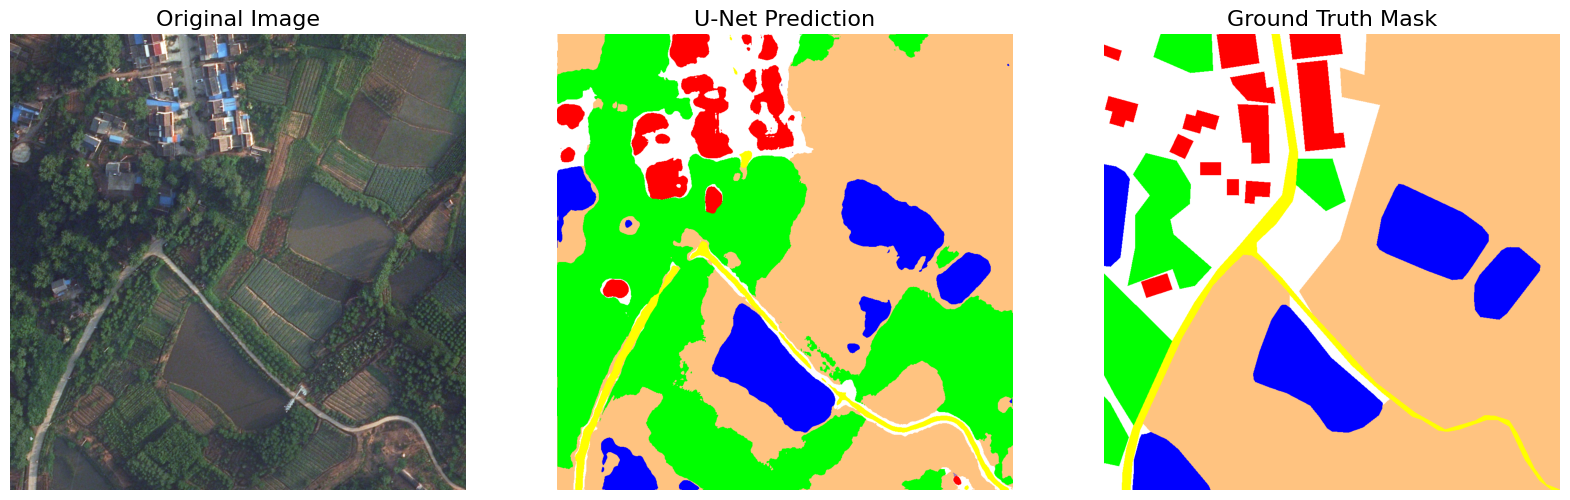

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


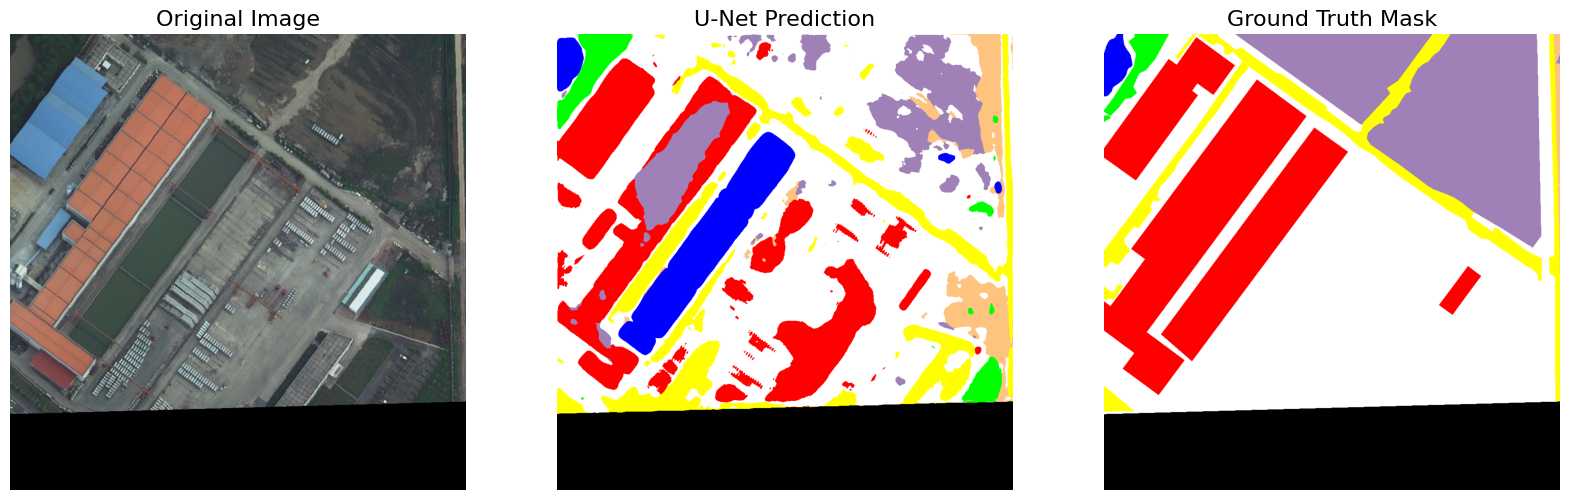

In [126]:
test_visual_multiclass(num_examples=2, model_path='/kaggle/working/seg_model.weights.h5', color_palette=color_palette)